In [1]:
%matplotlib inline
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
from scipy.optimize import curve_fit
from neo.core import AnalogSignal
from neuronunit.tests import TimeConstantTest

In [2]:
def make_sweep(total_time, amplitude, offset_time, tau, start_time, y0):
    # Construct x and y without an exponential signal
    sampling_rate = 10000*pq.Hz # samples per ms
    total_samples = (total_time * sampling_rate).simplified
    assert total_samples.dimensionality == pq.dimensionless
    total_samples = int(total_samples)
    noise_sigma = 0.1*pq.mV
    times = np.linspace(0,
                        float(total_time),
                        total_samples)*pq.ms
    vm = AnalogSignal(noise_sigma*np.random.randn(total_samples),
                      times=times,
                      t_start=start_time,
                      sampling_rate=sampling_rate.rescale(1/pq.ms))

    # Add the exponential signal
    samples_until_offset = ((offset_time - start_time) * sampling_rate).simplified
    assert samples_until_offset.dimensionality == pq.dimensionless
    samples_until_offset = int(samples_until_offset)
    exponential = amplitude*np.exp(-(times[samples_until_offset:]-(offset_time-start_time))/tau)
    vm[samples_until_offset:, 0] += exponential.reshape(-1,1)
    vm += y0
    return vm

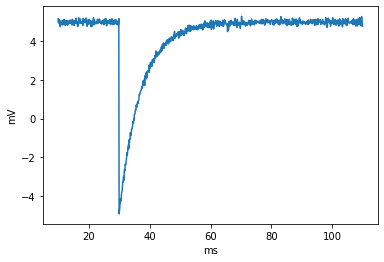

In [3]:
total_time = 100*pq.ms
start_time = 10*pq.ms
amplitude = -10*pq.mV
y0 = 5*pq.mV
offset_time = 30*pq.ms
tau = 7*pq.ms
    
vm = make_sweep(total_time, amplitude, offset_time, tau, start_time, y0)

plt.plot(vm.times.rescale('ms'), vm.rescale('mV'))
plt.xlabel(pq.ms.symbol)
plt.ylabel(pq.mV.symbol);

In [4]:
test = TimeConstantTest(observation={'mean':tau, 
                                     'std':np.sqrt(float(tau))*tau.units})
i = {'duration':total_time,
     'delay':offset_time}
tau_estimated = test.get_tau(vm, i).round(3)
print("Estimated tau = %s; Actual tau = %s" % (tau_estimated, tau))

Estimated tau = 6.991 ms; Actual tau = 7.0 ms


In [5]:
assert 0.95 < tau_estimated/tau < 1.05

In [6]:
amplitude_estimated, tau_estimated, y0_estimated = test.exponential_fit(vm, 30*pq.ms)
for var, units in [('amplitude', 'mV'), ('tau', 'ms'), ('y0', 'mV')]:
    print("Estimated %s: %.3g %s; Actual %s: %.3g %s" % \
          (var, locals()[var+"_estimated"], units, var, locals()[var], units))

Estimated amplitude: -9.97 mV; Actual amplitude: -10 mV
Estimated tau: 6.99 ms; Actual tau: 7 ms
Estimated y0: 5 mV; Actual y0: 5 mV


In [7]:
assert 0.95 < tau_estimated/tau < 1.05
assert 0.95 < amplitude_estimated/amplitude < 1.05
assert 0.95 < y0_estimated/y0 < 1.05